서비스명: VwsmAdstrdStorW
API URL: http://openapi.seoul.go.kr:8088/624141554e68666f3833424263756c/json/VwsmAdstrdStorW
필터 업종코드: CS300002 (편의점)
필터 분기 범위: 20221 ~ 20254
🚀 프로그램 시작
현재 시간: 2026-01-23 12:17:06

서울시 상권분석 API - 점포(행정동) 데이터 수집 시작
호출: 1~1,000 / 전체 949,748건 | 이번 추가(필터 후): 6 | 누적(필터 후): 6
호출: 1,001~2,000 / 전체 949,748건 | 이번 추가(필터 후): 14 | 누적(필터 후): 20
호출: 2,001~3,000 / 전체 949,748건 | 이번 추가(필터 후): 13 | 누적(필터 후): 33
호출: 3,001~4,000 / 전체 949,748건 | 이번 추가(필터 후): 11 | 누적(필터 후): 44
호출: 4,001~5,000 / 전체 949,748건 | 이번 추가(필터 후): 13 | 누적(필터 후): 57
호출: 5,001~6,000 / 전체 949,748건 | 이번 추가(필터 후): 9 | 누적(필터 후): 66
호출: 6,001~7,000 / 전체 949,748건 | 이번 추가(필터 후): 8 | 누적(필터 후): 74
호출: 7,001~8,000 / 전체 949,748건 | 이번 추가(필터 후): 9 | 누적(필터 후): 83
호출: 8,001~9,000 / 전체 949,748건 | 이번 추가(필터 후): 12 | 누적(필터 후): 95
호출: 9,001~10,000 / 전체 949,748건 | 이번 추가(필터 후): 12 | 누적(필터 후): 107
호출: 10,001~11,000 / 전체 949,748건 | 이번 추가(필터 후): 11 | 누적(필터 후): 118
호출: 11,001~12,000 / 전체 949,748건 | 이번 추가(필터 후): 12 | 누적(필터 후): 130
호출: 12,001~

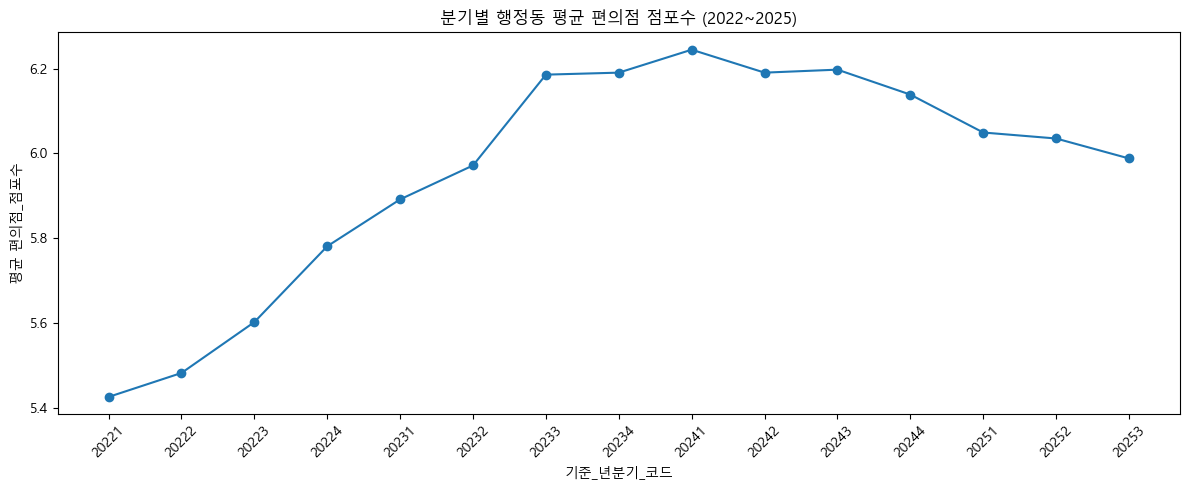

✅ 시각화 저장 완료: eda_편의점_분기별_평균점포수_2022_2025.png


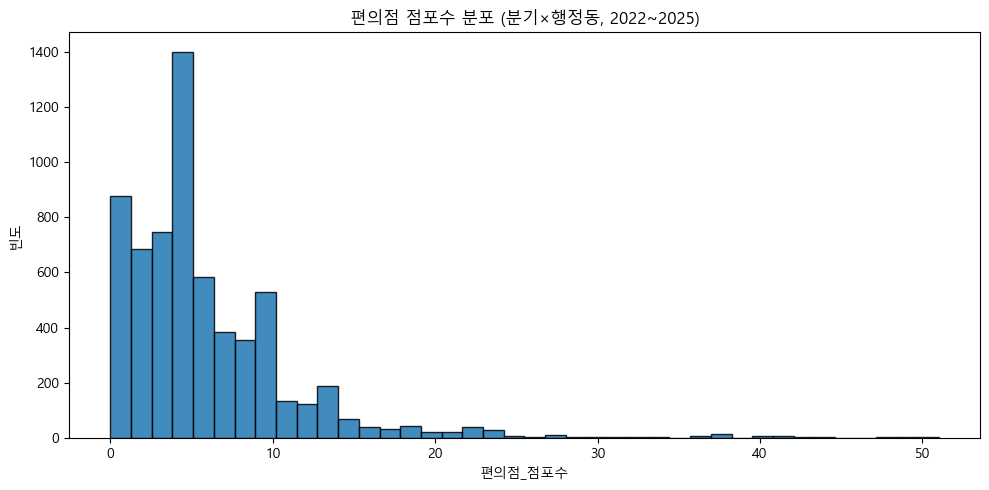

✅ 시각화 저장 완료: eda_편의점_점포수_분포_2022_2025.png


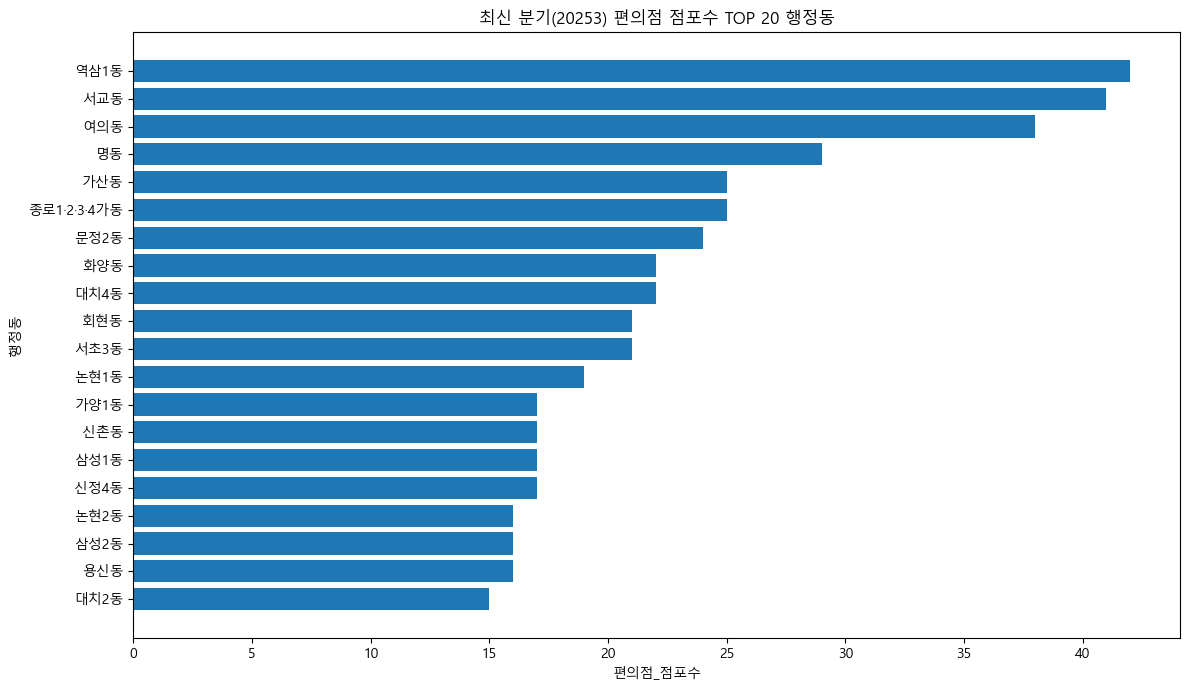

✅ 시각화 저장 완료: eda_편의점_TOP20_행정동_2022_2025.png

📌 4단계: 이상치 확인 (IQR) - 최신 분기 기준
최신 분기: 20253
Q1(25%): 3, Q3(75%): 8, IQR: 5
하한 경계: -4, 상한 경계: 16
하한 이상치: 0건
상한 이상치: 19건
✅ CSV 저장 완료: eda_편의점_상한이상치_2022_2025.csv

📊 EDA 요약 - 편의점 점포(행정동×분기)
원본 행 수(편의점, 2022~2025): 6,375
집계 행 수(분기×행정동): 6,375
중복(분기×행정동×업종): 0
최신 분기: 20253
이상치(최신 분기) 하한: 0 / 상한: 19

📊 EDA 완료!

🏁 프로그램 종료: 2026-01-23 12:25:00


In [1]:
"""
서울시 상권분석서비스 - 점포(행정동) API 호출 (OA-22172)
X변수: 편의점 밀집도(점포수)

- 서비스명: VwsmAdstrdStorW
- 필터:
  1) 기준년분기: 2022년~2025년 (20221 ~ 20254)
  2) 업종코드: CS300002 (편의점)
- 결과:
  기준년분기(STDR_YYQU_CD) × 행정동(ADSTRD_CD) 별 편의점 점포수(STOR_CO)
+ EDA(탐색적 데이터 분석) 포함
"""

import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import sys

# ============================================================
# Jupyter 출력 설정 (잘림 방지)
# ============================================================
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 설정
# ============================================================
API_KEY = "624141554e68666f3833424263756c"  # ✅ 여기만 본인 키로 교체해서 쓰면 됨
SERVICE_NAME = "VwsmAdstrdStorW"
BASE_URL = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/{SERVICE_NAME}"

# 편의점 업종코드
TARGET_SVC_CD = "CS300002"

# ✅ 2022년~2025년(전체 분기) 고정 필터: 20221 ~ 20254
TARGET_YEAR_START = 2022
TARGET_YEAR_END = 2025
TARGET_YYQU_LIST = [f"{y}{q}" for y in range(TARGET_YEAR_START, TARGET_YEAR_END + 1) for q in range(1, 5)]
TARGET_YYQU_SET = set(TARGET_YYQU_LIST)

# API 페이징
BATCH_SIZE = 1000
MAX_RETRIES = 3
SLEEP_SEC = 0.25

# 안전장치(선택): 너무 오래 걸릴 때 제한하고 싶으면 숫자 지정
MAX_ITERATIONS = 100000  # 충분히 크게
MAX_KEEP_ROWS = None     # 예: 50000 / None이면 제한 없음

print(f"서비스명: {SERVICE_NAME}")
print(f"API URL: {BASE_URL}")
print(f"필터 업종코드: {TARGET_SVC_CD} (편의점)")
print(f"필터 분기 범위: {TARGET_YYQU_LIST[0]} ~ {TARGET_YYQU_LIST[-1]}")
sys.stdout.flush()

# ============================================================
# API 호출 함수 (필터링해서 필요한 행만 저장)
# ============================================================
def fetch_filtered_data():
    """
    전체 데이터를 1000건 단위로 호출하면서
    - 편의점(CS300002)
    - 2022~2025 분기(20221~20254)
    조건을 만족하는 행만 저장
    """
    kept = []
    start = 1
    iteration = 0
    total_count = None

    print(f"\n{'='*60}")
    print("서울시 상권분석 API - 점포(행정동) 데이터 수집 시작")
    print(f"{'='*60}")
    sys.stdout.flush()

    while iteration < MAX_ITERATIONS:
        iteration += 1
        end = start + BATCH_SIZE - 1
        url = f"{BASE_URL}/{start}/{end}"

        for retry in range(MAX_RETRIES):
            try:
                response = requests.get(url, timeout=60)
                response.raise_for_status()
                result = response.json()

                # 서비스명 키 확인
                if SERVICE_NAME not in result:
                    # 어떤 키들이 있는지 출력해서 바로 원인 파악 가능하게
                    print("❌ API 응답에 SERVICE_NAME 키가 없습니다.")
                    print("응답 최상위 키:", list(result.keys())[:20])
                    if "RESULT" in result:
                        print("RESULT:", result.get("RESULT"))
                    return kept

                meta = result[SERVICE_NAME]

                # 응답 코드 확인
                if "RESULT" in meta:
                    code = meta["RESULT"].get("CODE")
                    msg = meta["RESULT"].get("MESSAGE")
                    if code != "INFO-000":
                        print(f"API 응답 코드: {code} / 메시지: {msg}")
                        if code == "INFO-200":
                            print("✅ 데이터 수집 완료 (더 이상 데이터 없음)")
                            return kept
                        break

                rows = meta.get("row", [])
                if not rows:
                    print("✅ 더 이상 데이터가 없습니다.")
                    return kept

                if total_count is None:
                    total_count = meta.get("list_total_count")

                # ---- 필요한 행만 필터링해서 저장 ----
                before = len(kept)
                for r in rows:
                    if r.get("SVC_INDUTY_CD") != TARGET_SVC_CD:
                        continue

                    yyqu = str(r.get("STDR_YYQU_CD"))
                    if yyqu not in TARGET_YYQU_SET:
                        continue

                    kept.append(r)

                    if MAX_KEEP_ROWS is not None and len(kept) >= MAX_KEEP_ROWS:
                        print(f"⚠️ MAX_KEEP_ROWS={MAX_KEEP_ROWS} 도달. 수집 중단.")
                        return kept

                after = len(kept)
                kept_added = after - before

                if total_count:
                    print(f"호출: {start:,}~{end:,} / 전체 {total_count:,}건 | 이번 추가(필터 후): {kept_added:,} | 누적(필터 후): {after:,}")
                else:
                    print(f"호출: {start:,}~{end:,} | 이번 추가(필터 후): {kept_added:,} | 누적(필터 후): {after:,}")
                sys.stdout.flush()

                start += BATCH_SIZE
                time.sleep(SLEEP_SEC)
                break

            except requests.exceptions.Timeout:
                print(f"⏰ 타임아웃 (시도 {retry+1}/{MAX_RETRIES}): {start}~{end}")
                sys.stdout.flush()
                time.sleep(2)
                continue

            except requests.exceptions.RequestException as e:
                print(f"❌ 요청 에러 (시도 {retry+1}/{MAX_RETRIES}): {e}")
                sys.stdout.flush()
                time.sleep(2)
                continue

            except Exception as e:
                print(f"❌ 처리 에러: {e}")
                sys.stdout.flush()
                return kept

        else:
            print(f"❌ {start}~{end} 구간 수집 실패, 다음으로 진행")
            start += BATCH_SIZE
            continue

    print(f"⚠️ 최대 반복 횟수 도달 ({MAX_ITERATIONS}회)")
    return kept

# ============================================================
# 컬럼명 한글 변환
# ============================================================
COLUMN_MAPPING = {
    "STDR_YYQU_CD": "기준_년분기_코드",
    "ADSTRD_CD": "행정동_코드",
    "ADSTRD_CD_NM": "행정동_명",
    "SVC_INDUTY_CD": "서비스업종_코드",
    "SVC_INDUTY_CD_NM": "서비스업종_명",
    "STOR_CO": "점포_수",
    "SIMILR_INDUTY_STOR_CO": "유사업종_점포_수",
    "OPBIZ_RT": "개업률",
    "OPBIZ_STOR_CO": "개업_점포_수",
    "CLSBIZ_RT": "폐업률",
    "CLSBIZ_STOR_CO": "폐업_점포_수",
    "FRC_STOR_CO": "프랜차이즈_점포_수",
}

# ============================================================
# 기준년분기 × 행정동 집계
# ============================================================
def aggregate_by_quarter_dong(df_raw):
    """
    기준_년분기_코드 × 행정동_코드 단위로 편의점 점포수 집계
    (혹시 중복이 있어도 안전하게 sum)
    """
    print(f"\n{'='*60}")
    print("📊 기준년분기 × 행정동 집계 (편의점 점포수)")
    print(f"{'='*60}")

    key_cols = ["기준_년분기_코드", "행정동_코드", "행정동_명"]
    df_agg = (
        df_raw.groupby(key_cols, as_index=False)
              .agg(편의점_점포수=("점포_수", "sum"))
    )

    print(f"집계 완료: {len(df_agg):,}행 (분기×행정동)")
    return df_agg

# ============================================================
# EDA
# ============================================================
def run_eda(df_raw, df_agg):
    """
    탐색적 데이터 분석 (EDA) - 편의점 점포(행정동×분기)
    """
    print(f"\n{'='*60}")
    print("📊 EDA (탐색적 데이터 분석) 시작 - 편의점 점포(행정동×분기)")
    print(f"{'='*60}")
    sys.stdout.flush()

    # =========================================================
    # 1단계: 원본 데이터 훑어보기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 1단계: 원본 데이터 훑어보기 (필터 후: 편의점, 2022~2025)")
    print(f"{'='*60}")

    print("\n[1-1] 데이터 크기")
    print("-" * 40)
    print(f"원본 행 수: {len(df_raw):,}")
    print(f"분기 수: {df_raw['기준_년분기_코드'].nunique():,}")
    print(f"행정동 수: {df_raw['행정동_코드'].nunique():,}")

    print("\n[1-2] 분기별 행 수")
    print("-" * 40)
    vc = df_raw["기준_년분기_코드"].value_counts()
    vc = vc.reindex(sorted(vc.index, key=lambda x: int(x)))
    print(vc.to_string())

    print("\n[1-3] 점포_수 기초통계(원본)")
    print("-" * 40)
    print(df_raw["점포_수"].describe().to_string())

    print("\n[1-4] 결측치 확인")
    print("-" * 40)
    missing = df_raw.isnull().sum()
    missing_with_values = missing[missing > 0]
    if len(missing_with_values) > 0:
        print(missing_with_values.to_string())
    else:
        print("✅ 결측치 없음!")

    print("\n[1-5] 중복 확인 (분기×행정동×업종)")
    print("-" * 40)
    dup_raw = df_raw.duplicated(subset=["기준_년분기_코드", "행정동_코드", "서비스업종_코드"]).sum()
    print(f"중복 건수: {dup_raw:,}")

    print("\n[1-6] 상위 5개 행 미리보기")
    print("-" * 40)
    print(df_raw.head())

    sys.stdout.flush()

    # =========================================================
    # 2단계: 집계 데이터 확인
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 2단계: 집계 데이터 확인 (분기×행정동 편의점_점포수)")
    print(f"{'='*60}")

    print("\n[2-1] 데이터 크기")
    print("-" * 40)
    print(f"집계 행 수: {len(df_agg):,}")
    print(f"분기 수: {df_agg['기준_년분기_코드'].nunique():,}")
    print(f"행정동 수: {df_agg['행정동_코드'].nunique():,}")
    print(f"컬럼: {df_agg.columns.tolist()}")

    print("\n[2-2] 기초 통계량 (편의점_점포수)")
    print("-" * 40)
    print(df_agg["편의점_점포수"].describe().to_string())

    print("\n[2-3] 상위 10개 행 미리보기")
    print("-" * 40)
    print(df_agg.head(10).to_string(index=False))

    sys.stdout.flush()

    # =========================================================
    # 3단계: 그래프로 보기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 3단계: 그래프로 보기")
    print(f"{'='*60}")

    # 정렬용 int 컬럼
    df_agg["_yyqu_int"] = df_agg["기준_년분기_코드"].astype(int)

    # 3-1. 분기별 행정동 평균 편의점 점포수
    q_mean = df_agg.groupby("_yyqu_int")["편의점_점포수"].mean().sort_index()

    plt.figure(figsize=(12, 5))
    plt.plot([str(x) for x in q_mean.index], q_mean.values, marker="o")
    plt.title("분기별 행정동 평균 편의점 점포수 (2022~2025)")
    plt.xlabel("기준_년분기_코드")
    plt.ylabel("평균 편의점_점포수")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("eda_편의점_분기별_평균점포수_2022_2025.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ 시각화 저장 완료: eda_편의점_분기별_평균점포수_2022_2025.png")

    # 3-2. 편의점 점포수 분포(전체)
    plt.figure(figsize=(10, 5))
    plt.hist(df_agg["편의점_점포수"], bins=40, edgecolor="black", alpha=0.85)
    plt.title("편의점 점포수 분포 (분기×행정동, 2022~2025)")
    plt.xlabel("편의점_점포수")
    plt.ylabel("빈도")
    plt.tight_layout()
    plt.savefig("eda_편의점_점포수_분포_2022_2025.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ 시각화 저장 완료: eda_편의점_점포수_분포_2022_2025.png")

    # 3-3. 최신 분기 기준 상위 20개 행정동(점포수)
    latest_quarter = df_agg["_yyqu_int"].max()
    df_latest = df_agg[df_agg["_yyqu_int"] == latest_quarter].copy()
    top20 = df_latest.sort_values("편의점_점포수", ascending=False).head(20)

    plt.figure(figsize=(12, 7))
    plt.barh(top20["행정동_명"][::-1], top20["편의점_점포수"][::-1])
    plt.title(f"최신 분기({latest_quarter}) 편의점 점포수 TOP 20 행정동")
    plt.xlabel("편의점_점포수")
    plt.ylabel("행정동")
    plt.tight_layout()
    plt.savefig("eda_편의점_TOP20_행정동_2022_2025.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ 시각화 저장 완료: eda_편의점_TOP20_행정동_2022_2025.png")

    sys.stdout.flush()

    # =========================================================
    # 4단계: 이상치(IQR) 확인 - 최신 분기 기준
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 4단계: 이상치 확인 (IQR) - 최신 분기 기준")
    print(f"{'='*60}")

    q1 = df_latest["편의점_점포수"].quantile(0.25)
    q3 = df_latest["편의점_점포수"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f"최신 분기: {latest_quarter}")
    print(f"Q1(25%): {q1:.0f}, Q3(75%): {q3:.0f}, IQR: {iqr:.0f}")
    print(f"하한 경계: {lower:.0f}, 상한 경계: {upper:.0f}")

    outliers_low = df_latest[df_latest["편의점_점포수"] < lower]
    outliers_high = df_latest[df_latest["편의점_점포수"] > upper]

    print(f"하한 이상치: {len(outliers_low):,}건")
    print(f"상한 이상치: {len(outliers_high):,}건")

    if len(outliers_low) > 0:
        outliers_low.sort_values("편의점_점포수").to_csv(
            "eda_편의점_하한이상치_2022_2025.csv", index=False, encoding="utf-8-sig"
        )
        print("✅ CSV 저장 완료: eda_편의점_하한이상치_2022_2025.csv")

    if len(outliers_high) > 0:
        outliers_high.sort_values("편의점_점포수", ascending=False).to_csv(
            "eda_편의점_상한이상치_2022_2025.csv", index=False, encoding="utf-8-sig"
        )
        print("✅ CSV 저장 완료: eda_편의점_상한이상치_2022_2025.csv")

    # =========================================================
    # EDA 요약
    # =========================================================
    print(f"\n{'='*60}")
    print("📊 EDA 요약 - 편의점 점포(행정동×분기)")
    print(f"{'='*60}")
    print(f"원본 행 수(편의점, 2022~2025): {len(df_raw):,}")
    print(f"집계 행 수(분기×행정동): {len(df_agg):,}")
    print(f"중복(분기×행정동×업종): {dup_raw:,}")
    print(f"최신 분기: {latest_quarter}")
    print(f"이상치(최신 분기) 하한: {len(outliers_low):,} / 상한: {len(outliers_high):,}")

    # 임시 컬럼 제거
    df_agg.drop(columns=["_yyqu_int"], inplace=True, errors="ignore")

    print(f"\n{'='*60}")
    print("📊 EDA 완료!")
    print(f"{'='*60}")

    return df_agg

# ============================================================
# 메인 실행
# ============================================================
if __name__ == "__main__":
    print("🚀 프로그램 시작")
    print(f"현재 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    sys.stdout.flush()

    # 1) 데이터 수집
    raw_rows = fetch_filtered_data()

    if not raw_rows:
        print("❌ 데이터 수집 결과가 없습니다. (API_KEY / SERVICE_NAME / 필터 확인)")
        sys.exit(0)

    # 2) DataFrame 변환
    df_raw = pd.DataFrame(raw_rows)

    # 3) 컬럼명 한글 변환
    existing_cols = {k: v for k, v in COLUMN_MAPPING.items() if k in df_raw.columns}
    df_raw = df_raw.rename(columns=existing_cols)

    # 4) 타입 정리
    df_raw["기준_년분기_코드"] = df_raw["기준_년분기_코드"].astype(str)
    df_raw["행정동_코드"] = df_raw["행정동_코드"].astype(str)
    df_raw["서비스업종_코드"] = df_raw["서비스업종_코드"].astype(str)
    df_raw["점포_수"] = pd.to_numeric(df_raw["점포_수"], errors="coerce").fillna(0).astype(int)

    # 5) 원본 저장 (필터 후 데이터)
    df_raw.to_csv("서울시_편의점점포_원본_2022_2025.csv", index=False, encoding="utf-8-sig")
    print(f"\n✅ 저장 완료: 서울시_편의점점포_원본_2022_2025.csv ({len(df_raw):,}건)")

    # 6) 집계(분기×행정동)
    df_agg = aggregate_by_quarter_dong(df_raw)

    # 7) 집계 저장
    df_agg.to_csv("서울시_편의점점포_분기_행정동_2022_2025.csv", index=False, encoding="utf-8-sig")
    print(f"✅ 저장 완료: 서울시_편의점점포_분기_행정동_2022_2025.csv ({len(df_agg):,}건)")

    # 8) EDA 실행
    run_eda(df_raw, df_agg)

    print(f"\n🏁 프로그램 종료: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


In [ ]:

# ## 1) (선그래프) “분기별 행정동 평균 편의점 점포수(2022~2025)”

# 이건 **각 분기마다**
# `(모든 행정동의 편의점 점포수 평균)`을 찍은 거야.

# * **2022년 초(20221) ~ 2024년 1분기(20241)**: 꾸준히 상승
#   대략 **5.4 → 6.25 수준까지 상승**
#   ⇒ 서울 전체로 보면 “행정동 평균 편의점 수가 늘어나는 흐름”이 있었음.

# * **2024년 2~3분기(20242~20243)**: 거의 정체(플래토)
#   ⇒ 성장세가 멈추는 구간.

# * **2024년 4분기(20244) ~ 2025년 3분기(20253)**: 완만한 하락
#   대략 **6.25 → 5.99 수준으로 소폭 감소**
#   ⇒ “평균적으로는” 출점이 둔화되거나 일부 감소한 신호.

# 그리고 그래프가 **20254가 아니라 20253에서 끝난다**는 건,

# * 2025 4분기 데이터가 아직 API에 없거나
# * 수집/필터 과정에서 해당 분기가 실제로 비어있었을 가능성이 큼.

# ---

# ## 2) (히스토그램) “편의점 점포수 분포(분기×행정동, 2022~2025)”

# 이 그래프는 가장 중요한 특징이 하나 있어:

# ### ✅ 분포가 “오른쪽으로 길게 늘어진 형태(강한 우측 꼬리, right-skewed)”

# * 대부분의 값이 **0~10개 사이**에 몰려 있음
# * 그런데 일부 행정동은 **20~50개까지**도 존재함 (꼬리가 김)

# 이 의미는 딱 2가지야.

# 1. **서울 대부분의 행정동은 편의점이 ‘많지 않다’**
# 2. “몇몇 특정 행정동”이 **압도적으로 많은 점포수를 가져서 평균을 끌어올린다**

# 즉, 선그래프에서 보이는 평균(5.4~6.2)은
# “서울의 전형적인 동”이라기보다 **상업지/핵심지의 영향이 섞인 평균값**일 가능성이 커.

# ---

# ## 3) (막대그래프) “최신 분기(20253) TOP 20 행정동”

# 여기서는 “꼬리를 만드는 주인공”이 누구인지가 드러나.

# 상위권을 보면:

# * **역삼1동(약 42), 서초4동(약 41), 여의동(약 38)**
# * 그 다음 **명동(약 28)**
# * 이후 **가산동/종로1·2·3·4가동(각 25 전후)**
# * 나머지도 15~24개 수준이 많음

# 이 패턴은 아주 전형적이야:

# * 업무/상업/관광/유동인구 큰 지역(강남권, 여의도, 명동, 종로, 가산 등)이 상위권을 차지함
# * 그래서 2번 히스토그램의 “긴 꼬리”가 생긴 거고,
# * 1번 평균도 이런 동들이 어느 정도 끌어올렸을 확률이 높아.

# ---

# ## 4) 세 그래프를 합쳐서 “한 문장 결론”

# **서울 편의점 점포수는 (시간적으로는) 2022→2024초까지 늘다가 2024말~2025에 완만히 줄었고, 
# (공간적으로는) 대부분 행정동은 0~10개 수준이지만, 몇몇 핵심 상권 동이 20~40개대로 매우 커서 
# 전체 분포를 강하게 왜곡(우측 꼬리)시키는 구조다.**


